# Quantum Fisher(man)

> Quantum Fisher(man) project developed for the <a href='https://qiskithackathoneurope.bemyapp.com'>IBM Qiskit Hackathon 2021</a>. We provide a toolkit to compute the overlap between quantum states. We apply it to obtain the quantum Fisher information from quantum circuits, which allows the optimization through advanced techniques such as the <a href='https://quantum-journal.org/papers/q-2020-05-25-269/pdf/'> quantum natural gradient</a>, as well as to study the loss landscape of such circuits. Furthermore, we provide a functionality to compute the overlap between quantum states from devices, enabling device-independent certification. 

## Quantum Fisher information

The Fisher information is a key metric widely used in physics and optimization. It has recently gathered great interest due to its applications in Machine Learning (ML), as it provides information about the local curvature of the Loss function, which can be leveraged to enhance vanilla gradient descent algorithms to perform [natural gradient](https://direct.mit.edu/neco/article/10/2/251/6143/Natural-Gradient-Works-Efficiently-in-Learning).

Its quantum version, the quantum Fisher information (QFI), plays a fundamental role in [multiple fields of quantum physics](https://arxiv.org/abs/2103.15191) such as quantum metrology, quantum information processing and quantum many-body physics. Furthermore, it lies at the core of recent quantum algorithms, such as the [quantum natural gradient](https://quantum-journal.org/papers/q-2020-05-25-269/pdf/), variational quantum imaginary time evolution or [quantum Boltzmann machines](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.021050).

However, the QFI is not directly related to any physical observable, which makes it very hard to measure. While fileds like quantum sensing or quantum machine learning would greatly benefit from it, its elevetaed cost makes it impractical to use in actual applications. 

A central element in the calculation of the QFI is the notion of distance between quantum states, which corresponds to their overlaps. In this hackathon we have developed a toolbox to compute the overlap between quantum states implementing various methods that do not require the explicit calculation of the state-vectors. Even more, they allow the computation of overlaps between mixed states and states in different devices. 

## Quantum Overlaps

The overlap between two states $\rho_0, \rho_1$ is defined as the trace of their product $\text{Tr}\left[\rho_0\rho_1\right]$ and measures the similarity between the two states. For pure states, the overlap coincides with the Fidelity and can be expressed as $|\langle\psi|\phi\rangle|^2$ for two pure states $|\psi\rangle, |\phi\rangle$. This quantity also defines the purity, which is the overlap of a state with itself and it is one for pure states. 

When dealing with large systems, the direct calculation of the overlap is impractical as it requires either full knowledge of the density matrices or the state vectors. Here, we provide three methods to compute the overlap between quantum states that do not require the explicit calculation of such quantities:

- **Compute-uncompute**: this method relies on the prepartion of a state through a unitary evolution of the zero state, followed by the "un-preparation" of another state to then measure the initial zero state. Then, the value of the overlap is the probability of measuring zero at the end. 
- **Swap test**: this method builds a circuit containing the two states to be compared and an additional qubit. The extra qubit serves as control for a set of controled swap gates between the states. The fidelity is obtained as a function of the probability to measure the zero state in the additional qubit. 
- **Random measurements**: this method performs a series of random measurements implmenting a series of random unitary gates. It then infers the value of the overlap from the resulting statistics from the random measurements. We extend the method compute the overlap across different quantum devices.

## Installation

Simply clone this repository to `what/ever/path/Quantum-Fisherman` and, from `what/ever/path/` run `pip install Quantum-Fisherman`. In case that you want to play around and edit the library, you can install it in editable mode with `pip install -e Quantum-Fisherman`.

## Basic usage

The package is designed to be very straightforward with a [simple API](https://borjarequena.github.io/Quantum-Fisherman/). It is prepared to import all the key functionalities at once as follows

In [ ]:
from fisherman.overlap.all import *

Then we need to import some qiskit functions in order to create our circuits.

In [ ]:
from qiskit import QuantumCircuit
from qiskit.opflow import CircuitStateFn
from qiskit.circuit import Parameter

First, we need to create the states from which we want to compute the overlap. In this case, we take a very simple single-qubit circuit with a parameterized rotation around the $x$ axis. 

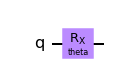

In [ ]:
qc = QuantumCircuit(1)
theta = Parameter('theta')
qc.rx(theta, 0)
qc.draw('mpl')

Now, we convert the circuit into a `StateFn` so that it eases the parameter assignment and operations. The three main methods corresponding to each of the briefly introduced algorithms are: 
- `compute_uncompute_overlap`
- `swap_test_overlap`
- `randomized_measurement_overlap`

Let us start by computing the overlap between two states with the three methods.

In [ ]:
state = CircuitStateFn(qc)
state_0 = state.assign_parameters({theta: 0.})
state_1 = state.assign_parameters({theta: 1.})

cu_overlap = compute_uncompute_overlap(state_0, state_1)
swap_overlap = swap_test_overlap(state_0, state_1)
rnd_overlap = randomized_measurement_overlap(state_0, state_1)

print(f"Overlap with comp-uncomp:         {cu_overlap:.3f}")
print(f"Overlap with swap test:           {swap_overlap:.3f}") 
print(f"Overlap with random_measurements: {rnd_overlap:.3f}")

All the three methods, while executing different algorithms, share the same functionalities. Thus, the main functionalities, while showcased with a single method at once, are applicable to all of them.

The most basic functionality is the calculation of the purity of a single state. This is achieved by providing a single input state and no additional state or value to the parameters. 

In [ ]:
purity = swap_test_overlap(state_0)
purity

array(1.)

Just as shown before, the next step is the computation of the overlap between two defined states. 

In [ ]:
overlap = randomized_measurement_overlap(state_0, state_1)
overlap

array(0.78292951)

We can compute the overlap between a reference state `state_0` and a series of states at once. We will create these states by providing a list of values into the dictionary that contains the parameters and binding them into the state. 

In [ ]:
param_dict = {theta: [0., 2.5, 5.3]} # arbitrary parameter values
states = state.bind_parameters(param_dict)
overlaps = compute_uncompute_overlap(state_0, states)
overlaps

array([1.        , 0.09942819, 0.77718717])

Finally, the last possibility is to provide a single parameterized state with a parameter dictionary contianing several values (or a single-element list). In this case, the method computes the overlap between all possible combinations of parameters returning a matrix. 

In [ ]:
overlaps = randomized_measurement_overlap(state, param_dict=param_dict)
overlaps

array([[ 1.00417878,  0.08015139,  0.8016555 ],
       [ 0.08015139,  1.03164371, -0.00432664],
       [ 0.8016555 , -0.00432664,  1.03249533]])

In the resulting matrix, the $i,j$ position is the overlap between parameter sets $i,j$. Therefore, in each row we find the overlap of each state with respect to the rest and the purities at the diagonal.

In [ ]:
overlaps.diagonal()

array([1.00417878, 1.03164371, 1.03249533])

Finally, we have the `device_independent_overlap` method, which computes the overlap between quantum states across devices. The behaviour si similar to that of the previous methods but with backends. 

The most straightforward functionality is the evaluation of two states each running on a backend. 

In [ ]:
from qiskit.providers.aer import QasmSimulator
from qiskit.test.mock import FakeVigo

In [ ]:
backends = [QasmSimulator(), QasmSimulator.from_backend(FakeVigo())]
device_independent_overlap(state_0, backends, state1=state_1)

array([[1.014965  , 0.69961107],
       [0.69961107, 0.83070439]])

This returns the overlap between `state_0` executed on the first backend and `state_1` on the second one. Notice that we also obtain the purites. If we only provide a backend, the reference state `state0` is simulated with `StatevectorSimulator`. 

Just like in the previous methods, can input a list of states to compare to a reference state. In this case, we may provide: 
- A single backend: `state0` is simulated and all states `state1` run in the backend.
- Two backends: `state0` runs on the first, all `state1` run on the second
- As many backends as `state1`: `state0` is simulated and `state1` run each on the backends
- `state0` + `state1` backends: `state0` runs on the first, `state1` states run on the rest. 

For further details about the underlying mechanisms of each method and their arguments, refer to the docs :) 